## Import Libraries 
---

This is where the libraries are imported. Also where I specify which features are categorical and needs scaling.

In [6]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as  plt
from sklearn import tree                                                        

MENS = 'mens'
WOMENS = 'womens'
TEST = 'test'
TRAIN = 'train'

# Columns in Data With Categorical Values- Must LabelEncode them
categorical_cols = ['hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 
                    'previous.hitpoint', 'server.is.impact.player', 'outcome']

# Columns in the Data That Should Be Scaled
scaled_data = ['serve', 'rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 
               'player.distance.travelled', 'player.impact.depth', 'previous.net.clearance',
               'player.impact.distance.from.center', 'player.depth', 'opponent.depth', 
               'player.distance.from.center', 'previous.speed',  'previous.depth', 
               'previous.distance.from.sideline', 'previous.time.to.net',
               'opponent.distance.from.center', ]

Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Import Data
---
Define functions to load data from csv files and preprocess the data (shuffle, drop, encode, and scale).

In [7]:
# Load Data and Return pandas dataframe
def load_tennis_data(gender, train='train'):
    assert gender == 'mens' or gender == 'womens'
    assert train == 'train' or train == 'test'
    csv_path = 'tennis_data/' + gender + '_' + train + '_file.csv'
    return pd.read_csv(csv_path)

# Return Shuffled Training Data- Reorder With ID as first column
def preprocess(data): 
    data = shuffle(data, random_state=42)
    cols = data.columns.tolist()
    new_cols = cols[-4:-3] + cols[0:-4]  + cols[-3:]
    data = data[new_cols]
    return data

# Return ID Column
def get_id(data):
    return data['id']

# Return df with useless features dropped- ID, Gender, Train
def get_feature_cols(data):
    data.drop('id', 1, inplace=True)   
    data.drop('gender', 1, inplace=True)
    data.drop('train', 1, inplace=True)
    return data

# Encode Categorical Data
def encode_data(data):
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)

    # Encode all the columns
    data[categorical_cols] = data[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))

    return data

# Scale Data
def scale_data(data):
    scaler = MinMaxScaler()
    data[scaled_data] = scaler.fit_transform(data[scaled_data])
    return data

## Split Input Data Into Train and Validation Sets
---
Define a function to take in the input data and split into training and validation sets. Mainly uses sklearn's train_test_split function.

In [8]:
# Return Train X, Train Y, Val X, Val Y, ID Columns
def split_train_validation_data(gender, test_size=0.2, random_state=None):
    train_data = load_tennis_data(gender, TRAIN)
    train_data= preprocess(train_data)
    train_id = get_id(train_data)
    train_data = get_feature_cols(train_data)
    train_data = encode_data(train_data)
    train_data = scale_data(train_data)
    # mens_train_data.head()

    # Split into training and validation sets
    train_mens, val_mens = train_test_split(train_data, test_size=test_size, random_state=random_state)

    # Split data into input and outputs
    X_train = train_mens.loc[:, train_mens.columns != 'outcome']
    Y_train = train_mens['outcome']
    X_val = val_mens.loc[:, val_mens.columns != 'outcome']
    Y_val = val_mens['outcome']
    
    # Reshape Data To Put Into NN
    X_train_np = X_train.values.reshape((-1, 24))
    Y_train_np = Y_train.reshape((-1,1))
    X_val_np = X_val.values.reshape((-1, 24))
    Y_val_np = Y_val.reshape((-1,1))
    return X_train_np, Y_train_np, X_val_np, Y_val_np, train_id

## Initialize Our Neural Network Model
---
Define a function to set up the neural network model. The model will have 3 hidden layers and use Adam as its' optimizer. The loss metric will be sparse_categorical_crossentropy since there are more than 2 categories to classify/predict.

In [9]:
# Create Model
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='random_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='lecun_uniform'))
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.add(Dense(3, activation='softmax', kernel_initializer='lecun_uniform'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

## Train, Evaluate, and Predict
---
Define functions to train and evaluate the model. The evaluating part involves graphing the training and validation error.

Also define a function to predict using the trained model.

In [10]:
# Build and Train Model
def train_and_evaluate_model(model, x_train, y_train, xval, yval, epochs, batch_size):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                         validation_data=(xval, yval))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return model

# Use model to predict
def prediction(model, data):  
    return model.predict(data)

## Train the Model
---
Train the model using the predefined functions above. 

First split the input data into training and validation. 

Next create the model.

Finally, train and evaluate the model. (Only 10 epochs listed here, but you optimally want more)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 1s 178us/step - loss: 1.0599 - acc: 0.4230 - val_loss: 1.0093 - val_acc: 0.4560
Epoch 2/10
4000/4000 [==============================] - 0s 93us/step - loss: 0.9893 - acc: 0.4870 - val_loss: 0.8978 - val_acc: 0.5810
Epoch 3/10
4000/4000 [==============================] - 0s 99us/step - loss: 0.8777 - acc: 0.5978 - val_loss: 0.7667 - val_acc: 0.7280
Epoch 4/10
4000/4000 [==============================] - 0s 86us/step - loss: 0.7861 - acc: 0.6540 - val_loss: 0.6880 - val_acc: 0.7410
Epoch 5/10
4000/4000 [==============================] - 0s 99us/step - loss: 0.7363 - acc: 0.6770 - val_loss: 0.6386 - val_acc: 0.7640
Epoch 6/10
4000/4000 [==============================] - 0s 88us/step - loss: 0.7116 - acc: 0.6953 - val_loss: 0.6265 - val_acc: 0.7630
Epoch 7/10
4000/4000 [==============================] - 0s 79us/step - loss: 0.6923 - acc: 0.6912 - val_loss: 0.6053 - val_acc: 0.7680
Epoch 

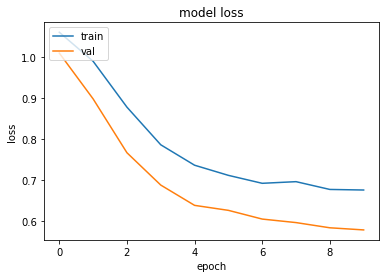

In [13]:
# Men's Model
X_train_m, Y_train_m, X_val_m, Y_val_m, train_id_m = split_train_validation_data(MENS, 0.2, random_state=42)

model_m = create_model()
model_m = train_and_evaluate_model(model_m, X_train_m, Y_train_m, X_val_m, Y_val_m, epochs=10, batch_size=32)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 1s 200us/step - loss: 1.0563 - acc: 0.4780 - val_loss: 0.9877 - val_acc: 0.5050
Epoch 2/10
4000/4000 [==============================] - 0s 89us/step - loss: 0.9086 - acc: 0.5980 - val_loss: 0.8208 - val_acc: 0.6520
Epoch 3/10
4000/4000 [==============================] - 0s 102us/step - loss: 0.7783 - acc: 0.6640 - val_loss: 0.7220 - val_acc: 0.6760
Epoch 4/10
4000/4000 [==============================] - 0s 106us/step - loss: 0.7075 - acc: 0.6975 - val_loss: 0.6742 - val_acc: 0.6850
Epoch 5/10
4000/4000 [==============================] - 0s 122us/step - loss: 0.6761 - acc: 0.7167 - val_loss: 0.6452 - val_acc: 0.6940
Epoch 6/10
4000/4000 [==============================] - 0s 107us/step - loss: 0.6436 - acc: 0.7365 - val_loss: 0.6183 - val_acc: 0.7410
Epoch 7/10
4000/4000 [==============================] - 0s 99us/step - loss: 0.6180 - acc: 0.7507 - val_loss: 0.5976 - val_acc: 0.7390
Ep

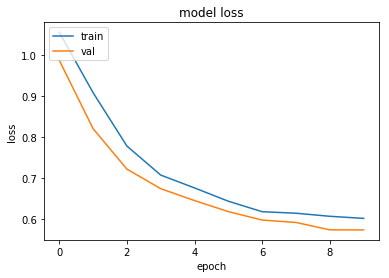

In [14]:
# Women's Model
X_train_w, Y_train_w, X_val_w, Y_val_w, train_id_w = split_train_validation_data(WOMENS, 0.2, 42)
model_w = create_model()
model_w = train_and_evaluate_model(model_w, X_train_w, Y_train_w, X_val_w, Y_val_w, epochs=10, batch_size=32)

## Format Submission
---
Format submission correctly according to competition rules.

In [34]:
# Correct submission format template
def create_result_file():
    csv_path = 'tennis_data/AUS_SubmissionFormat.csv'
    return pd.read_csv(csv_path)

# Add the correct gender for each test id  
def append_gender(data, gender):
    return str(data) + '_' + str(gender)

# Create the id column
def create_column_ids(mens_id, womens_id):
    mens_test_id_col = mens_id.apply(append_gender, args=('mens',))
    womens_test_id_col = womens_id.apply(append_gender, args=('womens',))

    combined_id = np.concatenate((mens_test_id_col, womens_test_id_col))
    
    return pd.DataFrame(combined_id)

# Preprocess Test Data
def preprocess_test(gender): 
    data = load_tennis_data(gender, TEST)
    data= preprocess(data)
    ids = get_id(data)
    data = get_feature_cols(data)
    data = encode_data(data)
    data = scale_data(data)
    data = data.loc[:, data.columns != 'outcome']
    data = data.values.reshape((-1, 24))
    return data, ids

test_data_m, test_id_m = preprocess_test(MENS)
test_data_w, test_id_w = preprocess_test(WOMENS)
column_ids = create_column_ids(test_id_m, test_id_w)
column_ids.head()

,0
0,2532_mens
1,7430_mens
2,6618_mens
3,2597_mens
4,5157_mens


In [28]:
# MENS PREDICTION
m_prediction = prediction(model_m, test_data_m)
m_prediction = pd.DataFrame(m_prediction)
m_prediction.head()

,0,1,2
0,0.018856,0.733372,0.247772
1,0.965714,0.029477,0.004809
2,0.232052,0.766503,0.001444
3,0.047025,0.952644,0.000331
4,0.269822,0.703331,0.026847


In [29]:
# WOMENS PREDICTION
w_prediction = prediction(model_w, test_data_w)
w_prediction = pd.DataFrame(w_prediction)
w_prediction.tail()

,0,1,2
995,0.436800,0.185206,0.377994
996,0.016616,0.092310,0.891075
997,0.412371,0.578559,0.009071
998,0.012106,0.168533,0.819361
999,0.000242,0.012258,0.987500


In [30]:
# Combine the test predictions
combined_test_predictions = pd.concat([m_prediction, w_prediction], axis=0)
combined_test_predictions.columns = ['FE', 'UE', 'W']
combined_test_predictions.reset_index(inplace=True, drop=True)
combined_test_predictions.head()

,FE,UE,W
0,0.018856,0.733372,0.247772
1,0.965714,0.029477,0.004809
2,0.232052,0.766503,0.001444
3,0.047025,0.952644,0.000331
4,0.269822,0.703331,0.026847


In [31]:
# Format the submission and place prediction in the correct column
def format_submission(predictions):
    format_file = create_result_file()
    final = pd.concat([column_ids, format_file[['train']], predictions], axis=1, )
    final.columns = ['submission_id', 'train', 'FE', 'UE', 'W']
    final = final.set_index(list(final[['submission_id']])).T
    correct_order = list(format_file['submission_id'])
    final_sorted = final[correct_order].T.reset_index()
    cols = ['submission_id', 'train', 'UE', 'FE', 'W']
    final_sorted = final_sorted[cols]
    return final_sorted

In [32]:
final_submission = format_submission(combined_test_predictions)
final_submission.head()

,submission_id,train,UE,FE,W
0,4314_mens,0.0,0.988561,0.008374,0.003064
1,3559_mens,0.0,0.228421,0.768826,0.002753
2,768_mens,0.0,0.840998,0.150060,0.008942
3,426_mens,0.0,0.590088,0.385234,0.024678
4,807_mens,0.0,0.902250,0.097677,0.000073


In [23]:
import time

# Save the predictions
timestr = time.strftime("%Y%m%d-%H%M%S")
def save_file(data):
    data.to_csv('Submissions/SubmissionNN' + timestr + '.csv', index=False)
save_file(final_submission)